# Exercise 7: ARIMAX versus ARDL models

# 1. Compute continuous quarterly returns:

In [1]:
#libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

!pip install arch
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from statsmodels import tsa
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel('BNP_CDS.xlsx', index_col=0)
df = df.sort_values(by='Date', ascending=True)

df_logret = np.log(df['Last Price'].iloc[1:]).diff().dropna()
df_logret_quart = (1 + df_logret)**(1/4) - 1
df_quarterly = df_logret_quart.resample('Q').ffill()*100

In [3]:
#split in train (from 01/01/2010 until 31/03/2022) and test (01/04/2022 until 30/09/2022):
df_train = df_quarterly.loc['2010-03-31' : '2021-03-31']
df_test = df_quarterly.loc['2021-06-30' : '2022-09-30']

Text(0, 0.5, 'Log-Return')

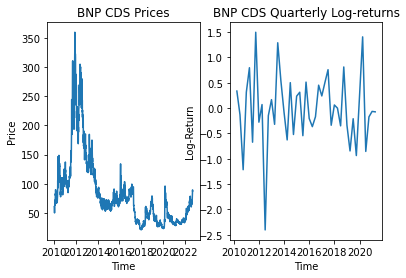

In [4]:
#================== Visual representation ===================

# Check the CDS price's fluctuation
plt.subplot(1, 2, 1)
plt.plot(df['Last Price'])
plt.title("BNP CDS Prices")
plt.xlabel('Time')
plt.ylabel('Price')
# Check the evolution of log-returns
plt.subplot(1, 2, 2)
plt.plot(df_train)
plt.title("BNP CDS Quarterly Log-returns")
plt.xlabel('Time')
plt.ylabel('Log-Return')

# 2. Visual inspection of ACF/PACF and Unit Root detection

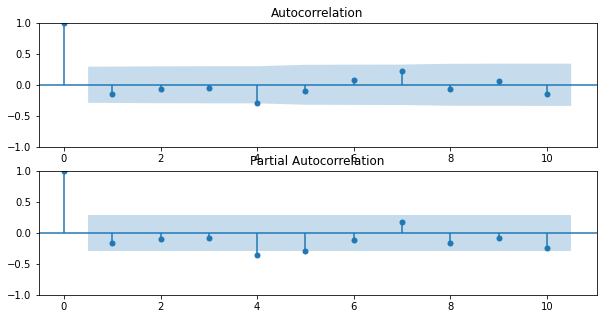

In [5]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_train, lags=10, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_train, lags=10, ax=ax2) 

In [6]:
test = adfuller(df_train)
df_adf = pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['Output'])
df_adf['Output']['Test Statistic Value'] = test[0]
df_adf['Output']['p-value'] = test[1]
df_adf['Output']['Lags Used'] = test[2]
df_adf['Output']['Number of Observations Used'] = test[3]
df_adf['Output']['Critical Value(1%)'] = test[4]['1%']
df_adf['Output']['Critical Value(5%)'] = test[4]['5%']
df_adf['Output']['Critical Value(10%)'] = test[4]['10%']
df_adf

,Output
Test Statistic Value,-4.892182
p-value,0.000036
Lags Used,3
Number of Observations Used,41
Critical Value(1%),-3.600983
Critical Value(5%),-2.935135
Critical Value(10%),-2.605963


The null hypothesis is rejected: the process is **stationary** (pvalue above thresholds & t-stat > critical value). There is no need for differentiating.

# Fitting an ARIMA model:

In [7]:
from itertools import product
ar_order = [0, 1, 2, 3, 4, 5]
ma_order = [0, 1, 2, 3, 4, 5]
arma_res = [list(orders) for orders in product(ar_order, ma_order)]
#     pprint.pprint(arma_res)

for n in arma_res:
    print('fitting: ar:{} - ma:{}'.format(*n)) 
    try:
        arma_model  = tsa.arima.model.ARIMA(df_train, order= (n[0], 0, n[1])).fit()
        n.extend([arma_model.aic / 1e3, arma_model.bic / 1e3])
    except Exception as exception:
        print(exception.__str__())
        n.extend([np.NaN, np.NaN])
    
res = pd.DataFrame(arma_res, columns = ['ar_order', 'ma_order', 'aic', 'bic'])
print('criterion\n', res)

fitting: ar:0 - ma:0
fitting: ar:0 - ma:1
fitting: ar:0 - ma:2
fitting: ar:0 - ma:3
fitting: ar:0 - ma:4
fitting: ar:0 - ma:5
fitting: ar:1 - ma:0
fitting: ar:1 - ma:1
fitting: ar:1 - ma:2
fitting: ar:1 - ma:3
fitting: ar:1 - ma:4
fitting: ar:1 - ma:5
fitting: ar:2 - ma:0
fitting: ar:2 - ma:1
fitting: ar:2 - ma:2
fitting: ar:2 - ma:3
fitting: ar:2 - ma:4
fitting: ar:2 - ma:5
fitting: ar:3 - ma:0
fitting: ar:3 - ma:1
fitting: ar:3 - ma:2
fitting: ar:3 - ma:3
fitting: ar:3 - ma:4
fitting: ar:3 - ma:5
fitting: ar:4 - ma:0
fitting: ar:4 - ma:1
fitting: ar:4 - ma:2
fitting: ar:4 - ma:3
fitting: ar:4 - ma:4
fitting: ar:4 - ma:5
fitting: ar:5 - ma:0
fitting: ar:5 - ma:1
fitting: ar:5 - ma:2
fitting: ar:5 - ma:3
fitting: ar:5 - ma:4
fitting: ar:5 - ma:5
criterion
     ar_order  ma_order       aic       bic
0          0         0  0.098216  0.101830
1          0         1  0.098941  0.104361
2          0         2  0.098623  0.105849
3          0         3  0.097967  0.107000
4          0      

In [8]:
#========= confirming order chosen ============
sm.tsa.arma_order_select_ic(df_train,max_ar=5,max_ma=5,ic='bic')['bic_min_order']

(1, 1)

# Order chosen is an ARIMA (1,0,1) (or should we choose an AR(1))

# Checking the absence/presence of a GARCH process:

First we construct the standardized residuals and run a normality test on them (Jarque-Bera test):

In [9]:
df_train_res = (df_train - np.mean(df_train)) / np.std(df_train)
nb_obs = len(df_train_res)

jb = sm.stats.stattools.jarque_bera(df_train_res, axis=0)
print(jb)

(9.186905410608686, 0.010117863992815968, -0.4831130957107672, 4.991504414423679)


This Jarque-Bera test is a goodness-of-fit test that returns the JB t-stat, p-value, skewness and the kurtosis. **we don't reject the null hypothesis of a normal distribution** (p-value being above the threshold) and confirm the absence of a GARCH process.

# Forecast an ARIMA(1,0,1) for the next 6 periods:

In [10]:
arma_model  = tsa.arima.model.ARIMA(df_train, order=(1,0,1)).fit()
arma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Last Price   No. Observations:                   45
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -43.284
Date:                Thu, 22 Dec 2022   AIC                             94.568
Time:                        23:59:42   BIC                            101.795
Sample:                    03-31-2010   HQIC                            97.262
                         - 03-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.023     -0.058      0.954      -0.046       0.043
ar.L1          0.6100      0.178      3.422      0.001       0.261       0.959
ma.L1         -1.0000    171.584     -0.006      0.995    -337.299     335.299
sigma2         0.3794     65.059      0.006      0.995    -127.134     127.893
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 6.25
Prob(Q):                              0.86   Prob(JB):                         0.04
Heteroskedasticity (H):               0.43   Skew:                            -0.50
Prob(H) (two-sided):                  0.11   Kurtosis:                         4.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

only the ar.L1 coefficient is significant (with p-value below 0.01)

In [11]:
forecast_arma = arma_model.forecast(6)
forecast_arma = pd.DataFrame({'Projected return' : forecast_arma})
forecast_arma

,Projected return
2021-06-30,0.176714
2021-09-30,0.107285
2021-12-31,0.064931
2022-03-31,0.039094
2022-06-30,0.023332
2022-09-30,0.013717


# Graph comparaison of forecasts versus real values:

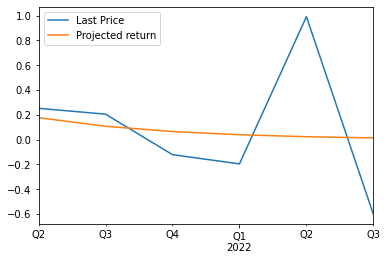

In [12]:
output = pd.concat([df_test, forecast_arma['Projected return']], axis=1)
output.plot()
plt.show()